<a href="https://colab.research.google.com/github/youngmin9/UX/blob/main/Chronic_stress%2C_Concentration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
from datetime import timedelta, datetime


In [ ]:
# 데이터 로드
df = pd.read_csv("/content/drive/Shareddrives/Algorithm/고객csv/240320/HR_hera240320.csv", encoding='cp949')
df.columns = ['TIME', 'HR']
df['TIME'] = pd.to_datetime(df['TIME'])

# 2024년 3월 8일 데이터만 필터링
df = df[(df['TIME'].dt.year == 2024) & (df['TIME'].dt.month == 3) & (df['TIME'].dt.day == 20)]

# 시간대 정보 제거
df['TIME'] = df['TIME'].dt.tz_localize(None)

In [ ]:

# RR 간격 및 Lomb-Scargle 계산 함수
def calculate_rr_lf_hf(df_segment):
    rr_intervals = 60000 / df_segment['HR'].values  # 밀리초 단위로 RR 간격 계산
    rr_times = np.linspace(0, len(rr_intervals) * 60 * 1000, num=len(rr_intervals))  # 각 RR 간격에 대한 시간 벡터 생성
    freqs = np.linspace(0.01, 0.4, 800)  # Hz 단위로 주파수 범위 설정
    power = lombscargle(rr_times, rr_intervals, freqs * 2 * np.pi, normalize=True)  # Lomb-Scargle 주기도 계산
    lf = np.trapz(power[(freqs >= 0.04) & (freqs <= 0.15)], freqs[(freqs >= 0.04) & (freqs <= 0.15)])  # LF 파워 계산
    hf = np.trapz(power[(freqs >= 0.15) & (freqs <= 0.4)], freqs[(freqs >= 0.15) & (freqs <= 0.4)])  # HF 파워 계산
    lf_hf_ratio = lf / hf if hf != 0 else 0  # LF/HF 비율 계산
    return lf, hf, lf_hf_ratio

# 만성 스트레스 및 집중력 몰입도 계산 및 시각화 데이터 준비
results = []

# 당일 0시부터 24시까지 처리 (일단 15분 간격)
start_time = datetime(2024, 3, 20)
end_time = datetime(2024, 3, 21)
current_time = start_time

while current_time + timedelta(minutes=30) < end_time:
    next_time = current_time + timedelta(minutes=30)
    df_segment = df[(df['TIME'] >= current_time) & (df['TIME'] < next_time)]

    if not df_segment.empty:
        lf, hf, lf_hf_ratio = calculate_rr_lf_hf(df_segment)
        chronic_stress = 124 - 0.18 * np.log(lf) if lf > 0 else np.nan  # 만성 스트레스 계산
        concentration = lf_hf_ratio * (-0.23)  # 집중력 몰입도 계산
        results.append((current_time, chronic_stress, concentration))

    current_time = next_time

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results, columns=['Time', 'Chronic Stress', 'Concentration'])
print(results_df)



                  Time  Chronic Stress  Concentration
0  2024-03-20 00:00:00      124.619177      -0.101143
1  2024-03-20 00:30:00      124.646881      -0.100168
2  2024-03-20 09:30:00      124.705235      -0.099266
3  2024-03-20 10:00:00      124.646362      -0.100164
4  2024-03-20 10:30:00      124.915397      -0.101701
5  2024-03-20 11:00:00      124.559344      -0.099867
6  2024-03-20 11:30:00      124.676849      -0.102773
7  2024-03-20 12:00:00      124.647696      -0.100386
8  2024-03-20 12:30:00      124.849919      -0.102532
9  2024-03-20 13:00:00      124.961961      -0.101938
10 2024-03-20 13:30:00      124.700289      -0.099319
11 2024-03-20 14:00:00      124.704041      -0.099304
12 2024-03-20 14:30:00      124.646989      -0.100192
13 2024-03-20 15:00:00      124.677470      -0.103770
14 2024-03-20 15:30:00      124.620919      -0.101206
15 2024-03-20 16:00:00      124.636399      -0.099955
16 2024-03-20 16:30:00      124.703129      -0.099250
17 2024-03-20 17:00:00      

# **결측값 있는 경우**

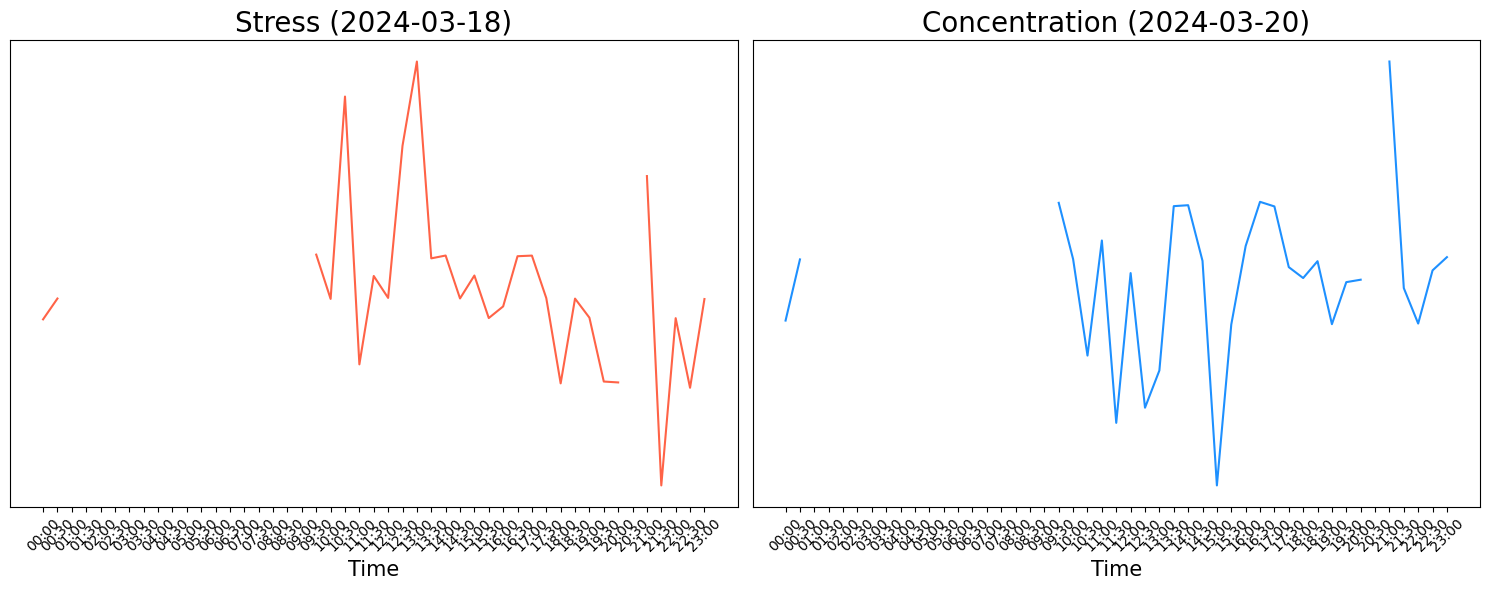

In [ ]:
from datetime import timedelta, datetime
start_time = datetime(2024, 3, 20, 1, 0)
end_time = datetime(2024, 3, 20, 9, 0)


empty_df = pd.DataFrame([[start_time,None,None]],columns=results_df.columns)
current_time = start_time

while current_time < end_time:
  current_time = current_time + timedelta(minutes=30)
  empty_df_new = pd.DataFrame([[current_time,None,None]],columns=results_df.columns)
  empty_df = pd.concat([empty_df,empty_df_new])

results_df_total = pd.concat([results_df.iloc[:2],empty_df,results_df.iloc[2:]],ignore_index = True)
results_df_total.to_csv('/content/drive/Shareddrives/Algorithm/우석csv/240320/Hera_old.csv')

#시각화
# 가정: results_df_total이 이미 존재하고, 'Time' 열이 datetime 타입이라고 가정합니다.
# 'Time' 열에서 '시:분' 형태의 문자열을 생성합니다.
time_labels = results_df_total['Time'].dt.strftime('%H:%M')

plt.figure(figsize=(15, 6))

# 첫 번째 그래프
plt.subplot(1, 2, 1)
plt.plot(time_labels, results_df_total['Chronic Stress'], label='Chronic Stress', color='tomato')
plt.title('Stress (2024-03-18)', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.gca().axes.yaxis.set_visible(False)  # Y축 레이블 숨기기
plt.xticks(rotation=45)  # X축 눈금 레이블 회전

# 두 번째 그래프
plt.subplot(1, 2, 2)
plt.plot(time_labels, results_df_total['Concentration'], label='Concentration', color='dodgerblue')
plt.title('Concentration (2024-03-20)', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.gca().axes.yaxis.set_visible(False)  # Y축 레이블 숨기기
plt.xticks(rotation=45)  # X축 눈금 레이블 회전

plt.tight_layout()
plt.show()
#results_df_total.to_csv("/content/drive/Shareddrives/Algorithm/우석csv/240320/HR_hera240320.csv")

In [ ]:
#결측값 없는 경우
results_df.to_csv("/content/drive/Shareddrives/Algorithm/우석csv/martin_240318.csv")

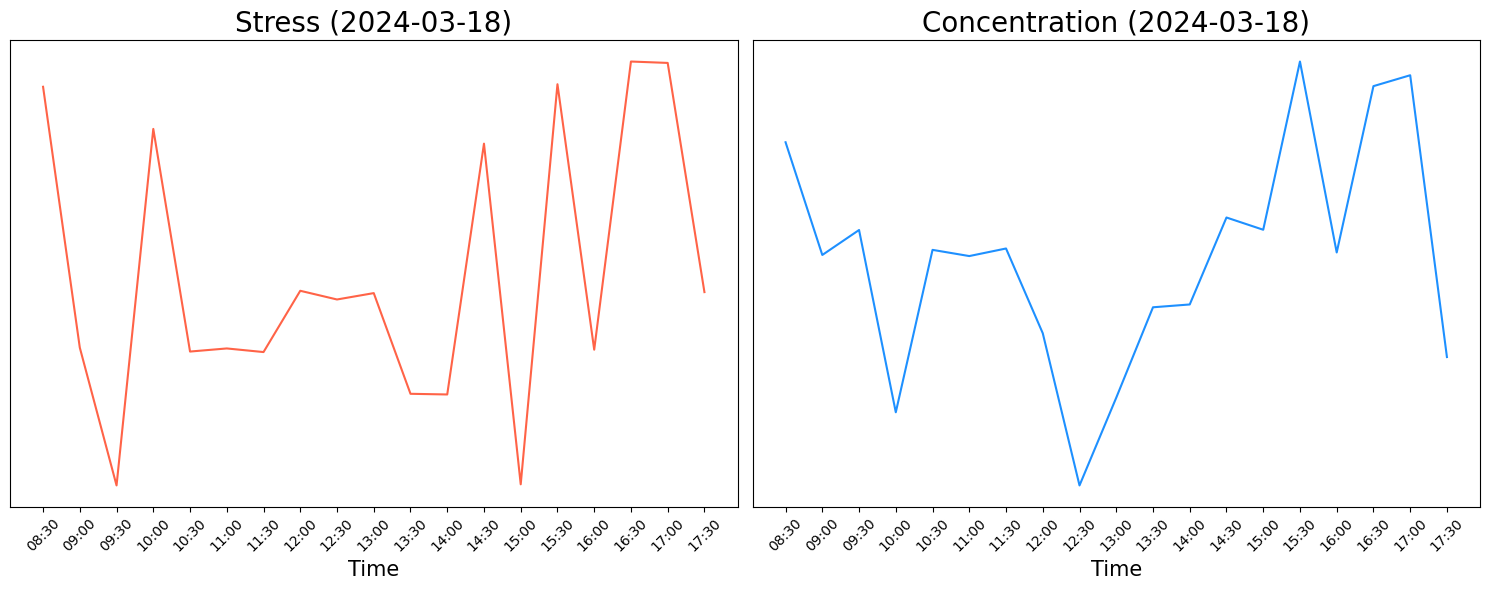

In [ ]:
#결측값 없는 경우


# 가정: results_df_total이 이미 존재하고, 'Time' 열이 datetime 타입이라고 가정합니다.
# 'Time' 열에서 '시:분' 형태의 문자열을 생성합니다.
time_labels = results_df['Time'].dt.strftime('%H:%M')

plt.figure(figsize=(15, 6))

# 첫 번째 그래프
plt.subplot(1, 2, 1)
plt.plot(time_labels, results_df['Chronic Stress'], label='Chronic Stress', color='tomato')
plt.title('Stress (2024-03-18)', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.gca().axes.yaxis.set_visible(False)  # Y축 레이블 숨기기
plt.xticks(rotation=45)  # X축 눈금 레이블 회전

# 두 번째 그래프
plt.subplot(1, 2, 2)
plt.plot(time_labels, results_df['Concentration'], label='Concentration', color='dodgerblue')
plt.title('Concentration (2024-03-18)', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.gca().axes.yaxis.set_visible(False)  # Y축 레이블 숨기기
plt.xticks(rotation=45)  # X축 눈금 레이블 회전

plt.tight_layout()
plt.show()



In [ ]:
#우석 작업 part

%pip install piecewise-regression

시간 지정 분석을 시행하고 싶으시면 숫자 1을, 아니면 아무 숫자를 입력하세요.4
Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -381.26         True   4.4861e-05 
1                                   False              
2                    -371.57         True   3.9379e-05 
3                    -365.45         True   3.8556e-05 
4                                   False              
5                                   False              

Min BIC (Bayesian Information Criterion) suggests best model

                    Breakpoint Regression Results                     
No. Observations     

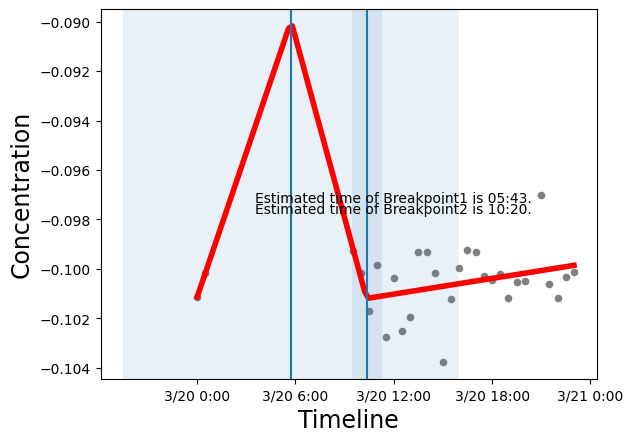

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -121.71         True      0.34582 
1                    -120.08         True      0.28996 
2                    -113.74         True      0.28613 
3                                   False              
4                    -99.881         True      0.28996 
5                                   False              

Min BIC (Bayesian Information Criterion) suggests best model

                    Breakpoint Regression Results                     
No. Observations                       29
No. Model Parameters     

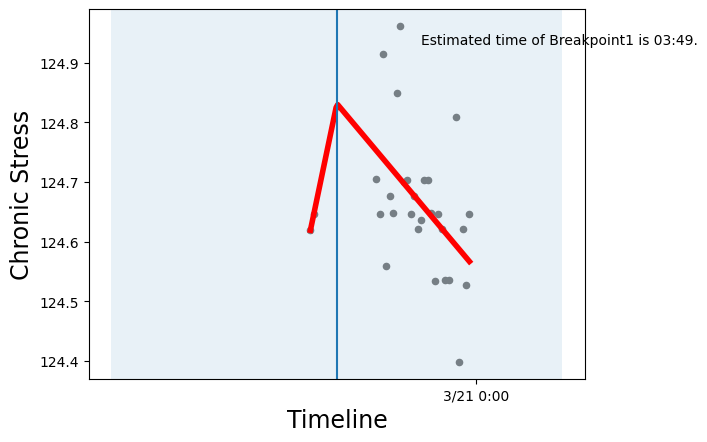

In [ ]:

import pandas as pd
import numpy as np
import datetime
import sys
#sys.path.append('C:/Users/정우석/AppData/Local/Programs/Python/Python310/Lib/site-packages')
import piecewise_regression
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

df = pd.read_csv('/content/drive/Shareddrives/Algorithm/우석csv/240320/Hera_old.csv')
df.columns = ['Index', 'TIME', 'Chronic_Stress', 'Concentration']
TIME = df.TIME

df['TIME'] = pd.to_datetime(df['TIME'])
Day = df['TIME'].dt.day
Hour = df['TIME'].dt.hour
Minute = df['TIME'].dt.minute
Second = df['TIME'].dt.second

#plotting할 때 쓸 변수 만들어놓기.. 시작 날짜로..
day_min=Day.min()
mediator = day_min

#변수 지정
X = Hour
YY = Second + 60*Minute + 3600*Hour + 3600*24*Day
Z = df['Concentration']
ZZ = df['Chronic_Stress']

#DF 구성
dict_main = {
    'Hour' : X,
    'Timestamp': YY,
    'Concentration': Z,
    'Chronic_Stress': ZZ}
df_main = pd.DataFrame(dict_main)
df_main = df_main[df_main['Concentration'].notnull()]
df_main.drop(df_main[(df_main['Concentration'] == 0)].index, inplace=True)
df_main = df_main[df_main['Chronic_Stress'].notnull()]
df_main.drop(df_main[(df_main['Chronic_Stress'] == 0)].index, inplace=True)

column_names = ["Concentration", "Chronic_Stress"]

#시간별 분석을 진행할 것인지?
analysis_select = int(input('시간 지정 분석을 시행하고 싶으시면 숫자 1을, 아니면 아무 숫자를 입력하세요.'))
if analysis_select == 1:
    start_hour = int(input('분석을 시작할 시간(hour, 24시간 기준)을 입력해 주세요 : '))
    end_hour = int(input('분석을 끝낼 시간(hour, 24시간 기준)을 입력해 주세요 : '))
    df_main = df_main.loc[(df_main.Hour >= start_hour) & (df_main.Hour < end_hour), ]

list_Timestamp = df_main.loc[:,'Timestamp'].to_list()
list_Concentration = df_main.loc[:,'Concentration'].to_list()
list_Chronic_Stress = df_main.loc[:,'Chronic_Stress'].to_list()

#모델의 bic를 전달받아 최소 bic를 갖는 breakpoint 개수 출력 함수 정의
def min_cal(bic_list, value_num):
    for index, value in enumerate(bic_list):
        if value == value_num:
            bic_list[index] = 99999999
    global min_bic
    min_bic = min(bic_list)
    min_bic_num = bic_list.index(min_bic)
    return min_bic_num

for analysis_name in column_names:
    list_analysis_name = eval('list_' + analysis_name[0:])

    #최적 model 찾기
    ms = piecewise_regression.ModelSelection(list_Timestamp,list_analysis_name, max_breakpoints=5)
    ms.models

    #최적 model의 breakpoint 개수 찾기
    bic_list = [d['bic'] for d in ms.model_summaries]
    min_bic_num = min_cal(bic_list, None)
    if min_bic_num == 0:
        min_bic_num = min_cal(bic_list, min_bic)

    #breakpoint 개수에 따른 modelling - 최적 모델 개수에 대해서 시행
    pw_fit = piecewise_regression.Fit(list_Timestamp,list_analysis_name,n_breakpoints=min_bic_num)
    pw_fit.summary()

    #최적 model이 converge하지 않을 경우 (무슨 이유인지 종종 발생함) 다시 계산
    while not pw_fit.best_muggeo:
        min_bic_num = min_cal(bic_list, min_bic)
        pw_fit = piecewise_regression.Fit(list_Timestamp,list_analysis_name,n_breakpoints=min_bic_num)
        pw_fit.summary()
        if pw_fit.best_muggeo:
            break

    #plotting
    pw_fit.plot_data(color="grey", s=20)
    pw_fit.plot_fit(color="red", linewidth = 4)
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()

    #Estimated breakpoint를 plot 위에 표시
    estimates = pw_fit.best_muggeo.best_fit.estimates
    for i in range(min_bic_num):
        raw_estimates = estimates["breakpoint{}".format(i+1)]["estimate"]
        break_day = raw_estimates // (24*3600)
        break_hour = (raw_estimates % (24*3600)) // 3600
        break_minute = ((raw_estimates % (24*3600)) % 3600) // 60
        plt.text(24*3600*day_min + 12*3600, df[analysis_name].max()-(i+1)*(df[analysis_name].max()-df[analysis_name].min())/16,"Estimated time of Breakpoint" + str(i+1) + " is " + str(int(break_hour)).zfill(2) + ":" + str(int(break_minute)).zfill(2) + ".", verticalalignment='bottom' , horizontalalignment='center' )

    #plotting x축 바꾸기
    tick_val = []
    tick_lab = []
    if analysis_select == 1:
        for i in range (start_hour, end_hour + (end_hour - start_hour)//4, (end_hour - start_hour)//4 + 1):
            tick_val.append (24*3600*day_min + 3600*i)
            tick_lab.append (f'3/{day_min} {i}:00')
    else:
        for i in range (24*3600*day_min, YY.max()+21600, 21600):
            j=6*(i-24*3600*day_min)/21600
            if j>=24:
                day_min = day_min + 1
                j=j-24
            j = int(j)
            tick_val.append (i)
            tick_lab.append (f'3/{day_min} {j}:00')
    plt.xticks(tick_val, tick_lab)

    analysis_name = analysis_name.replace('_', ' ')
    plt.xlabel("Timeline", fontsize=17)
    plt.ylabel(analysis_name, fontsize=17)
    plt.show()